In [1]:
%matplotlib inline
# File with functions used in this notebook
from pre_processing_funk import *
from analysis_funk import *
from clust_funk import *

/Users/iZbra1/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Data Scrapping and download

In [2]:
# File Urls
data_raw_path = '../data/raw'
notebook_path = '../../notebook'
url_paris_listings_data = 'http://data.insideairbnb.com/france/ile-de-france/paris/2018-08-13/data/listings.csv.gz'
url_paris_reviews_data = 'http://data.insideairbnb.com/france/ile-de-france/paris/2018-08-13/data/reviews.csv.gz'
name_of_main_folder = 'Project-Data-Mining'
project_path = '/Users/iZbra1/Documents/Jupyter-DS/K2DS/Projects/Project-Data-Mining/notebook'


In [ ]:
# Download the listings
confirm_files(name_of_main_folder, url_paris_listings_data)

In [4]:
# Download the reviews
confirm_files(name_of_main_folder, url_paris_reviews_data)

# Change directory if necessary.
os.chdir(notebook_path)


Path Confirmed
reviews.csv is downloaded


In [2]:
int_data = '../data/raw/paris_listings.csv'
listings_columns_with_dates = ['last_scraped','host_since','first_review','last_review']
usecols = ['id','last_scraped']+columns_phase_1['summry']+columns_phase_1['host_info']+columns_phase_1['location']+columns_phase_1['prdct']+columns_phase_1['guest_info']+columns_phase_1['rvws']
listings = pd.read_csv(int_data, index_col=0, parse_dates=listings_columns_with_dates, usecols=usecols) # 
print(listings.shape)

(62848, 61)


In [3]:
listings.head()

,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
3109,2018-07-09,zen and calm,Appartement très calme de 50M2 Belle lumière D...,I bedroom appartment in Paris 14,I bedroom appartment in Paris 14,NaN,NaN,"ligne 13 and RER B, Ligne 4",NaN,yes I can help you out,...,10.0,10.0,10.0,10.0,10.0,t,flexible,f,f,0.27
5396,2018-07-09,Explore the heart of old Paris,"Cozy, well-appointed and graciously designed s...","Small, well appointed studio apartment at the ...","Cozy, well-appointed and graciously designed s...","You are within walking distance to the Louvre,...",The staircase leading up to the apartment is n...,The flat is close to two or three major metro ...,"The flat includes its own modern bathroom, a w...",We expect guests to operate rather independent...,...,9.0,10.0,10.0,10.0,9.0,t,strict_14_with_grace_period,f,f,1.21
7397,2018-07-09,MARAIS - 2ROOMS APT - 2/4 PEOPLE,"VERY CONVENIENT, WITH THE BEST LOCATION !",PLEASE ASK ME BEFORE TO MAKE A REQUEST !!! No ...,"VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA...",NaN,Important: Be conscious that an apartment in a...,Metro station HÖTEL-DE-VILLE is 100 meters close.,NaN,NaN,...,9.0,10.0,10.0,10.0,9.0,f,moderate,f,f,2.47
7964,2018-07-08,Large & sunny flat with balcony !,Very large & nice apartment all for you! - Su...,hello ! We have a great 75 square meter apartm...,Very large & nice apartment all for you! - Su...,NaN,NaN,NaN,You have access to all the apartment.,"We are there to welcome you, give you keys and...",...,10.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,f,f,0.06
8522,2018-07-09,GREAT FLAT w/ CITY VIEW,NaN,Really nice flat located in the 20th district ...,Really nice flat located in the 20th district ...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,f,moderate,f,f,0.01


### 1. Analysis to build a summary
The original dataset consists of more than 60 columns. After simple-checking them, I was able to come up with 61 columns that appeared useful. Furthermore, in the attempt to reduce this dimensionality curse (even more), the following steps will analyze each column and determine whether it provides useful information to our study or not. 

#### A. Get rid of the null-valued rows 

*I will remove those listings with few missing values of important columns such as name, description or price.*

In [4]:
# SUMMARY
# Listings that have a  null name?       
lwn_name = listings.loc[listings.name.isnull()].index.values
# Listings that have a  null summary?       
lwn_summary = listings.loc[listings.summary.isnull()].index.values
# Listings that have a  null description?   
lwn_desc = listings.loc[listings.description.isnull()].index.values

# HOST_INFO
# Listings where host_since is  null       (28)
lwn_host_since = listings.loc[listings.host_since.isnull()].index.values
# Listings where host_is_superhost is  null ()
lwn_host_is_superhost = listings.loc[listings.host_is_superhost.isnull()].index.values

# LOCATION : 
# Uniform to zipcode standard format (5 digits)
listings['zipcode'] = listings.zipcode.apply(clean_zip)
outliers_and_wrong_zipcodes = listings.loc[(listings.zipcode<=75000)|(listings.zipcode>76000),'zipcode'].unique()


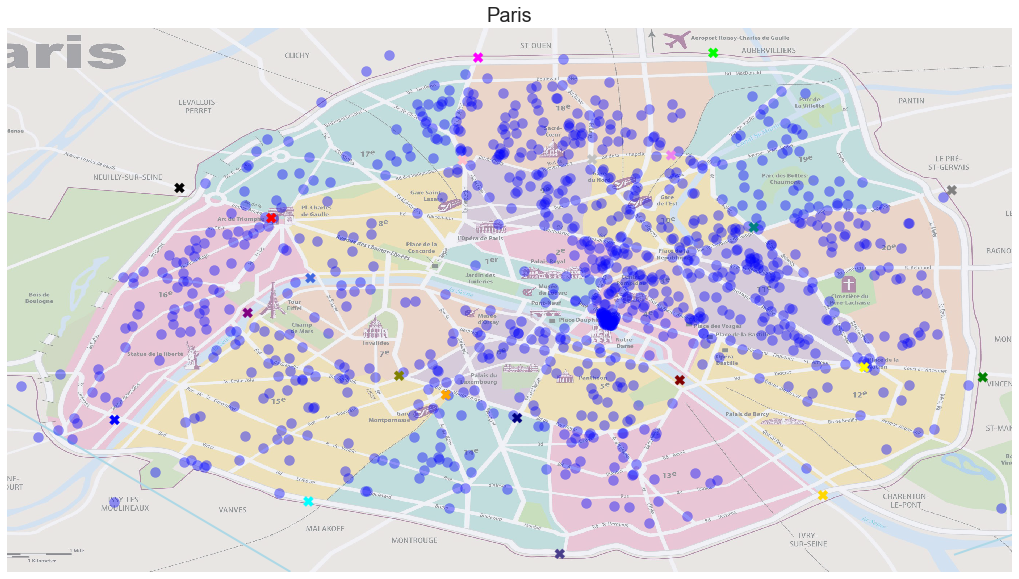

In [5]:
# Listings with null zipcodes
coord = listings.loc[listings.zipcode==0,['latitude','longitude', 'zipcode']]#.sample(frac=0.1)
print_map(coord, res = 'c', arrn_lim = 1, title_map='Paris', l_size=100, l_color = 'blue', l_alf=0.4)


921 listings with an incorrect zipcode. Add that to the 269 listings that have a zipcode corresponding to the suburbs of Paris and it's still a number small enough to have little effect on the results of this study. Unfortunately it's difficult and time consuming to manually assign the correct zipcode to these listings by analyzing it's geographic coordinates. There might be a method (for future research) that can Therefore I will proceed to remove them. 

In [6]:
# Merge 75106, 75116 to 75006 and 75016 respectively
listings.loc[listings.zipcode==75106, 'zipcode'] = 75006
listings.loc[listings.zipcode==75116, 'zipcode'] = 75016

In [7]:
# Add to the black list those zipcodes that are null or have a value of 1 or correspond to the suburbs
lwn_num_zip = listings.loc[(listings.zipcode==0)|(listings.zipcode==1)|(listings.zipcode.isin(outliers_and_wrong_zipcodes))].index.values

# Listings where location is not exact
lwn_loc_exact = listings.loc[listings.is_location_exact=='f'].index.values

# PRODUCT
# Listings where bedroom or bathroom are null
lwn_beds_baths = listings.loc[(listings.bathrooms.isnull())|(listings.beds.isnull())].index.values

# REVIEWS
# Listings with null reviews
lwn_rvws = listings.loc[(listings.review_scores_accuracy.isnull())|
                        (listings.review_scores_checkin.isnull())|
                        (listings.review_scores_cleanliness.isnull())|
                        (listings.review_scores_communication.isnull())|
                        (listings.review_scores_rating.isnull())|
                        (listings.review_scores_location.isnull())|
                        (listings.review_scores_value.isnull())                   
                       ].index.values

In [8]:
# Build the Blacklist: 
blacklist = list(set(np.concatenate((lwn_name,lwn_summary, lwn_desc,
                                lwn_host_since,lwn_host_is_superhost,
                                lwn_num_zip,lwn_loc_exact,lwn_beds_baths, lwn_rvws), axis=0)))

# Null-Free Updated Dataframe
null_free_row_data_index = listings.loc[~listings.index.isin(blacklist)].index.values

#### B. Remove duplicate listings. 

In [9]:
print(listings.loc[null_free_row_data_index].shape[0], listings.loc[null_free_row_data_index].drop_duplicates().shape[0])


39091 39091


#### C. Get rid of redundant (correlated) columns:
There is a logic column indicating whether the listing's **location is exact**. I will keep those listings whose said value is true. The columns: **space, neighborhood_overview, notes, transit, access, interaction and house_rules** are inecessary for this study. 

The columns **host_location** should be related with *host_neighbourhood* however an initial exploration shows that most locations happen to be in a place other than what the neighbourhood specifies. Since I cannot rely on the location I will remove it and keep the neighbourhood as it's shown more consistency (less unique values). 

***Is host_response_time correlated with host_response_rate?***

*FYI: host_response_rate and host_response_time have 28% missing values*

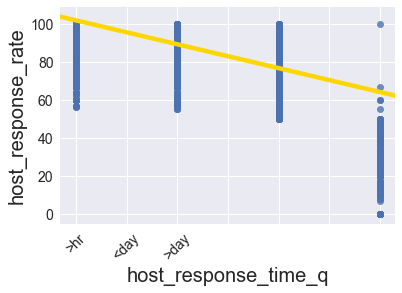

In [10]:
# Remove the % symbol from host_response_rate and convert to float
listings.loc[listings.host_response_rate.notnull(),'host_response_rate'] = listings.loc[listings.host_response_rate.notnull(),'host_response_rate'].replace('[\%,]', '', regex=True).astype(float)


# Get the correlation coeficients from host_response_time and host_response_rate
host_response_time_vs_rate = listings.loc[listings.host_response_time.notnull(),['host_response_time','host_response_rate']]

# Convert host_response_rate to float
host_response_time_vs_rate.host_response_rate = host_response_time_vs_rate.host_response_rate.astype('float')

# Quantify host_response_time (<h:5, >h:10, <d:15, >d:20) With this logic the lowest response_time gets 
# the highest_rate, thus a negative correlation is expected. 
host_response_time_vs_rate['host_response_time_q'] = host_response_time_vs_rate.loc[:,'host_response_time'].apply(lambda x: quantify_host_response_time(x)).astype('int')
host_response_time_vs_rate.reset_index(inplace=True)
host_response_time_vs_rate.drop(['id','host_response_time'], axis=1, inplace=True)

# Get correlation 
fig_hrt_hrr = sns.regplot('host_response_time_q', 'host_response_rate', host_response_time_vs_rate, line_kws = {"color":"gold"}, ci=None)
fig_hrt_hrr.set_xticklabels(['<hr', '>hr','<day','>day'], rotation=45)
plt.show()

In [14]:
host_response_time_vs_rate.corr()

,host_response_rate,host_response_time_q
host_response_rate,1.000000,-0.614475
host_response_time_q,-0.614475,1.000000


*0.6 is considered somewhat correlated, however in the regplot above the categorical values of the host_response_time dont differ amongst themselves in terms of **host_response_rate** with the exception of the "within a few days" time which receives a significantly lower rate. So the variable with most information is the host_response_time as the rate might be biased.*

***Looks like city and smart_location are pretty much the same except for the latter having an addendum of: ", France"***

In [15]:
city_vs_smart_loc = listings.loc[null_free_row_data_index,['city','smart_location']]
# Remove the addendum: ", France"
city_vs_smart_loc['z'] = city_vs_smart_loc.smart_location.replace(', France', '', regex=True)
# Get those listings where city is not the same as smart_location:
city_vs_smart_loc.loc[city_vs_smart_loc.city!=city_vs_smart_loc.z, columns_phase_1['location']]

,city,zipcode,smart_location,latitude,longitude,is_location_exact
id,,,,,,
8771276,Paris,NaN,"Paris, Switzerland",NaN,NaN,NaN


*39365 listings have the same values for city and smart_location. 
Except for a few outliers (index=8771276), city and smart location are pretty much the same. 
So I will keep city and get rid of **smart_location**.*

*** Is the summary the same as the description?***

In [14]:
sumry_vs_desc = listings.loc[null_free_row_data_index,['summary','description']]
sumry_vs_desc.head(2)

,summary,description
id,,
5396,"Cozy, well-appointed and graciously designed s...","Cozy, well-appointed and graciously designed s..."
7397,"VERY CONVENIENT, WITH THE BEST LOCATION !","VERY CONVENIENT, WITH THE BEST LOCATION ! PLEA..."


*It seems that the summary is the 1st sentence of the description. Only 8065 listings have their summaries identical to their descriptions, the rest of the description contains extra information from what the summary has.*

In [45]:
sumry_vs_desc['z'] = sumry_vs_desc.apply(lambda row: sum_desc_comp(row.summary, row.description), axis=1)
sumry_vs_desc.loc[sumry_vs_desc.z==0].shape

(1038, 3)

*Looks like 1038 (2.7%) listings have a different summary than its description. I will get rid of the **summary** since the description already has it.*

### 2. Build the summary:

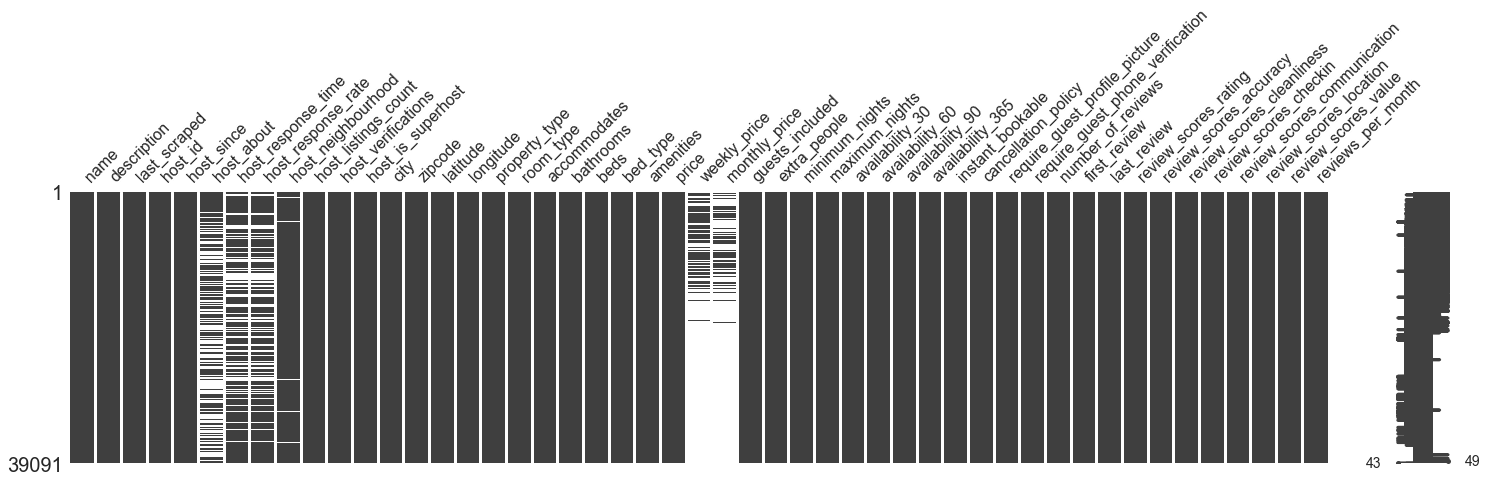

In [12]:
import missingno as msn
sumry_col = []
for section in columns_phase_2:
    sumry_col+=columns_phase_2[section]
data = listings.loc[null_free_row_data_index, sumry_col]
msn.matrix(data, figsize=(25,5))

#### A. Perform the adequate type conversions

In [13]:
# Convert host_listings_count from float to int
data.host_listings_count = data.host_listings_count.astype(int)
data.beds = data.beds.astype(int)

# Convert host_is_superhost, instant_bookable, require_guest_profile_picture, require_guest_phone_verification to bool
ctb = {'f': False, 't': True, 'nan':np.nan}
data.host_is_superhost = data.host_is_superhost.map(ctb)
data.instant_bookable = data.instant_bookable.map(ctb)
data.require_guest_profile_picture = data.require_guest_profile_picture.map(ctb)
data.require_guest_phone_verification = data.require_guest_phone_verification.map(ctb)

# Convert the response_rate, price values (price, extra_people, weekly and monthly price) into float
data.loc[:,'host_response_rate'] = data.host_response_rate.astype(float)
data.loc[:,'price'] = data.price.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'extra_people'] = data.extra_people.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'weekly_price'] = data.weekly_price.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'monthly_price'] = data.monthly_price.replace('[\$,]', '', regex=True).astype(float)


#### B. In-depth analysis of correlated columns with missing values
***How is the monthly price calculated, What is the trend in ‘weekly_price', 'monthly_price’?***

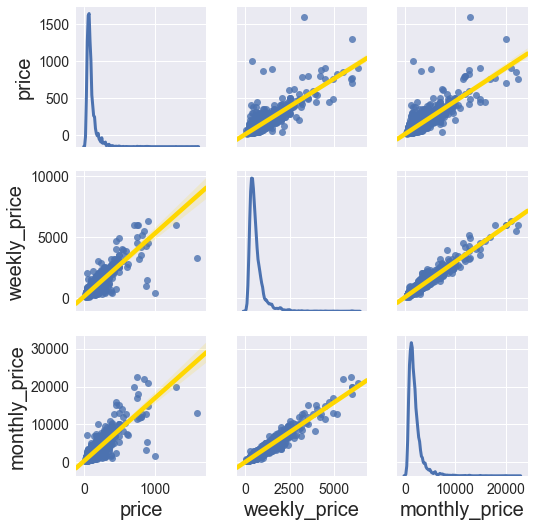

In [18]:
p = data.loc[:,['price','weekly_price','monthly_price']]
prices = p.loc[(p.weekly_price.notnull())&(p.monthly_price.notnull())]
fig_price = sns.pairplot(prices.iloc[:,0:3], kind="reg", plot_kws={'line_kws':{'color':'gold'}}, diag_kind="kde")

In [19]:
prices['week_ratio'] = prices.apply(lambda row: row.weekly_price/row.price, axis=1)
prices['month_ratio'] = prices.apply(lambda row: row.monthly_price/row.price, axis=1)
prices.loc[:,['week_ratio','month_ratio']].describe().T

,count,mean,std,min,25%,50%,75%,max
week_ratio,5743.0,6.579793,1.795672,0.399399,5.714286,6.394366,7.142857,55.972973
month_ratio,5743.0,21.507174,6.533513,1.601602,17.777778,21.000000,24.444444,197.513514


*Price has a positive correlation with its weekly and monthly homologues (as it is expected) at a rate of 6.58 and 21.5 respectively. Having noted that, I can now remove these 2 columns and continue with the analysis.*

***What is the meaning of the availabilities columns?***

In [15]:
data.loc[:,['availability_30', 'availability_60', 'availability_90', 'availability_365']].corr()

,availability_30,availability_60,availability_90,availability_365
availability_30,1.000,0.917,0.858,0.493
availability_60,0.917,1.000,0.960,0.579
availability_90,0.858,0.960,1.000,0.630
availability_365,0.493,0.579,0.630,1.000


The data uses public information compiled from the Airbnb web-site including the availability calendar for 365 days in the future, and the reviews for each listing.
According to the website, "some hosts might not keep their calendar updated, or have it highly available even though they live in the entire home/apartment". 

Having said that, the columns: 'availability_30','availability_60','availability_90','availability_365' represent the number of days the listing is available for booking within the threshold of days. In other words its availability metric. The first 3 columns are only necessary if this study needs to compare the listings availability within 30, 60 or 90 days. Keeping that in mind, I will only keep the availability for the whole year ahead (July 2019). 

***review_scores_rating vs review_scores_value***

*review_scores_value is not the mean nor the median of the rest review_scores. So it must be a manually entered value qualifying some other aspect of the listing. As for the review_scores_rating, there isn't a linear correlation to it from the other scores, so in other words, it's formula remains hidden. All is there to know is that it acts as another KPI.*

***host_listings_count***

Originaly the *host_listings_count* shows value of 0 (meaning the hosts has no listing) which is confusing as it means that the host that is refered in a row shows that it has no listings. Therefore I will just count the listings each host has here in this dataset and replace the current host_listings_count with that value. 

In [14]:
hl_count = data.loc[:,['host_id','host_listings_count']].groupby('host_id').count().sort_values('host_listings_count', ascending=False)
data = pd.merge(data.reset_index().set_index('host_id'), hl_count, right_index=True, left_index=True)
data.reset_index(inplace=True)
data.set_index('id', inplace=True)
# Drop host_listings_count_x
data.drop('host_listings_count_x', axis=1, inplace=True)
# Rename the column host_listings_count_y to host_listings_count
data.rename(columns={'host_listings_count_y': 'host_listings_count'}, inplace=True)

## City-Zipcode Second cleaning filter

Assuming zipcodes are correctly assigned to listings I will proceed to correct the city names (or districts)

Most of the zipcodes in Paris have the city value "Paris" in it, the other (most common) value is more likely to be the correct district name, so I will get that name and assign it in the city value of the respective zipcode

In [15]:
zip_data = data.loc[:,['city','zipcode','latitude','longitude']].set_index('zipcode')

In [17]:
'''Takes a zipcode and returns the most common city assigned to the zipcode'''
def get_com_den_city(z):
    if isinstance(zip_data.loc[z,'city'], str):
        return zip_data.loc[z,'city'].lower()
    else:
        com_den = zip_data.loc[z,'city'].value_counts()
        for city_value in com_den.index:
            if city_value.lower() != 'paris':
                return city_value.lower()

In [18]:
# Get the common city for each of the zipcodes in Paris
zip_paris = pd.Series(data.zipcode.unique()[(data.zipcode.unique()>=75000)&(data.zipcode.unique()<76000)]).reset_index()
zip_paris.rename(columns={0:'zipcode'}, inplace=True)
zip_paris['city'] = zip_paris.zipcode.apply(get_com_den_city)

zip_paris.drop('index', axis=1, inplace=True)
# Manually fix the outlier (zipcode=75106)
zip_paris.loc[zip_paris.zipcode==75106, 'city'] = 'paris-16e-arrondissement'

In [19]:
zip_paris.set_index('zipcode', inplace=True)
zip_paris.head()

,city
zipcode,
75004,paris-4e-arrondissement
75005,paris-5e-arrondissement
75015,paris-15e-arrondissement
75006,paris-6e-arrondissement
75009,paris-9e-arrondissement


In [20]:
# Apply research on THE data dataframe 
# Prep dataframe to be merged
data.drop('city',axis=1, inplace=True)
data.reset_index(inplace=True)
data.set_index('zipcode', inplace=True)
# Merge
data = pd.merge(data, zip_paris, right_index=True, left_index=True)
# Prep dataframe post-merge
data.reset_index(inplace=True)
data.set_index('id', inplace=True)
data.rename(columns={'city_y':'district', 'id':'listing_id'}, inplace=True)

In [21]:
# From the listings coordinates, let's calculate the center of mass per zipcode and 
# through the LOF method get the wrong zipcodes. 
# Correct them by assigning the nearest zipcode center. 

centroids, outliers = get_centroids_and_outliers(data)


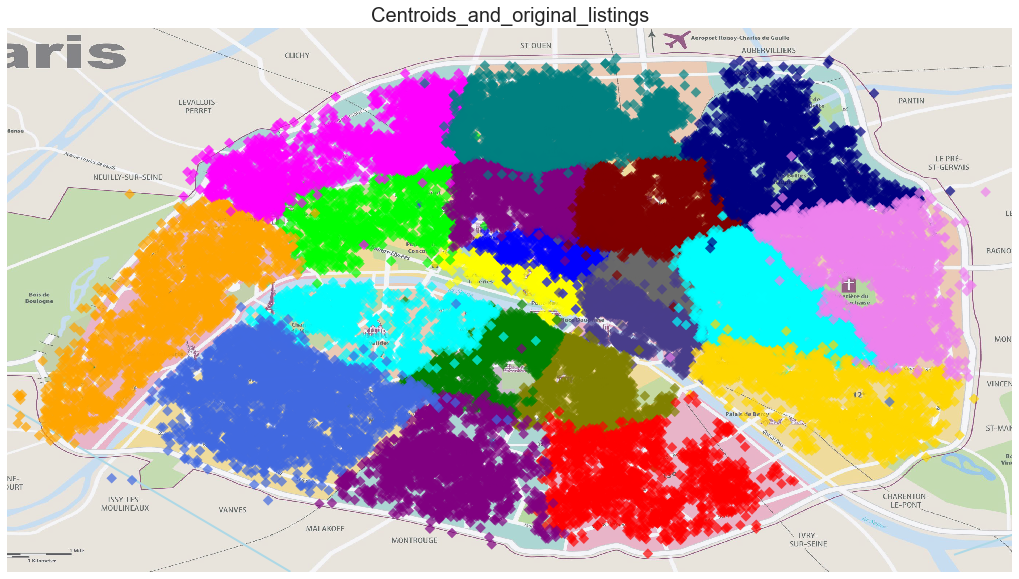

In [22]:
# Original data set with outliers: 
coord = data.loc[:,['latitude','longitude', 'zipcode']]#.sample(frac=0.1)
coord['color'] = coord.zipcode.apply(lambda x: cpzl[x])
print_paris(centroids, coord, 'c', 'Centroids_and_original_listings', False, 1, 0.6)


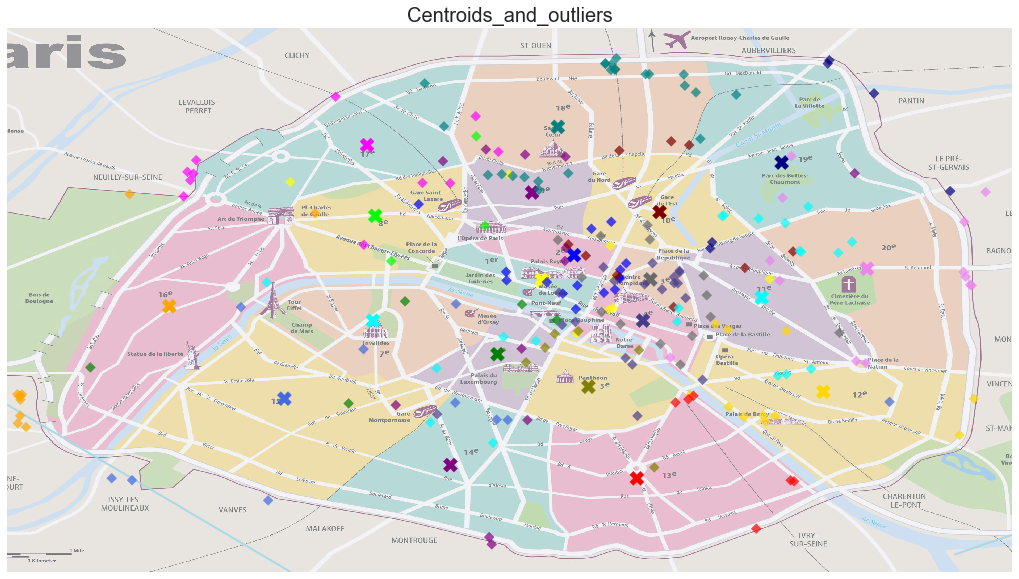

In [23]:
print_paris(centroids, outliers, 'c', 'Centroids_and_outliers', False, 1, 0.5)

In [24]:
# Function that returns the zipcode having the minimum euclidean
# distance with a particular listing x. Uses local variable centroids

def get_distEuclid(x):
    d = np.sqrt((centroids.longitude - x.longitude)**2 + (centroids.latitude - x.latitude)**2)
    return d.idxmin()

In [25]:
# For every outlier perform k nearest centroids (k=1). 
# In the centroids set, we compute the distance to every outlier listing and the 
# function get_distEuclid will return with the zipcode whose centroid is the nearest. 

outliers['zipcode'] = outliers.apply(lambda x: get_distEuclid(x), axis=1).astype(int)
# Update the color of the listing to its corresponding zipcode
outliers['color'] = outliers.zipcode.apply(lambda x: cpzl[x])



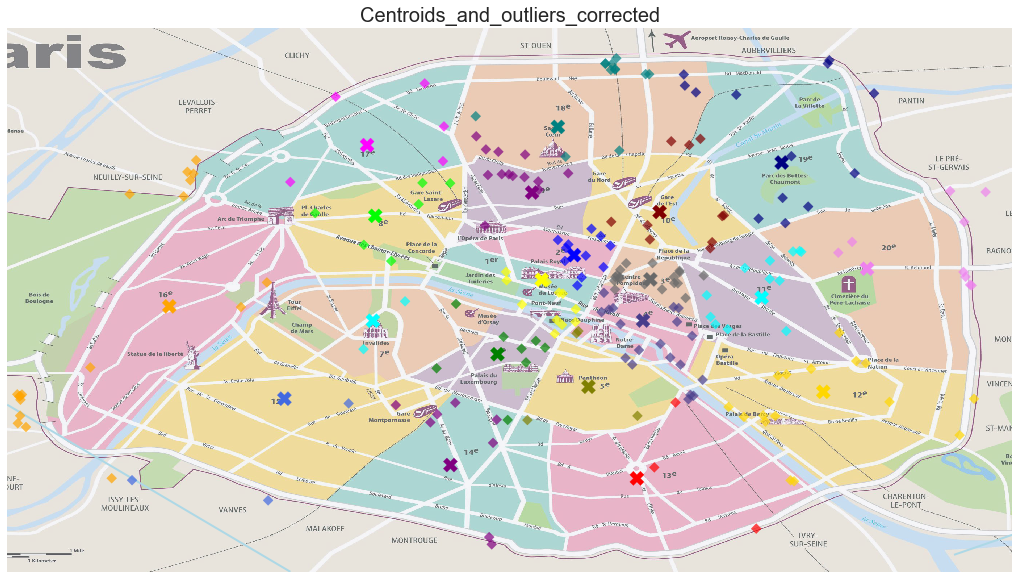

In [26]:
print_paris(centroids, outliers, 'c', 'Centroids_and_outliers_corrected', False, 1, 0.6)



In [27]:
# Add corrected outliers into database

data = pd.merge(data, outliers.loc[:,['zipcode']], right_index=True, left_index=True, how='outer')
# Get the index of those listings whose zipcode_y is not null. 
new_zip = data.loc[data.zipcode_y.notnull()].index.values
data.loc[new_zip,'zipcode_x'] = data.loc[new_zip,'zipcode_y']

data['zipcode'] = data.zipcode_x.astype(int)
data.drop(['zipcode_x','zipcode_y'], axis=1, inplace=True)

### 4. Save

In [28]:
#Create Folder processed 
data.to_csv('../data/interim/data.csv')

# Get the trouristy attractions and their coordinates

In [34]:
def get_paris_attractions_coordinates():
    
    urls = ['https://latitude.to/map/fr/france/cities/paris/articles/page/'+str(n_page)+'#articles-of-interest' for n_page in range(2,85)]
    url_list = ['https://latitude.to/map/fr/france/cities/paris']+urls
    paris_attractions = pd.DataFrame(columns=['Name','latitude','longitude'])
    
    
    for n_page in range(len(url_list)):

        my_page = requests.get(url_list[n_page])
        if my_page.status_code != 200:
            print('Error scraping',url)
            pass
        clear_output()
        print('Fetching coordinates ..', int((n_page+1)/len(url_list)*100),'%')  
        
        soup = BeautifulSoup(my_page.content, 'html.parser')

        attr_name = soup.select("h3.title a")
        attr_coord = soup.select("div.act a.show")

        paris_attr = [[attr_name[a].get_text().lower(),
                   float(attr_coord[a].get('data-lat')), 
                   float(attr_coord[a].get('data-lng'))] for a in range(len(attr_name))]
        p_attr = pd.DataFrame(paris_attr, columns=['Name','latitude','longitude'])

        paris_attractions = pd.concat([paris_attractions, p_attr])

    print('saving onto ../data/interim/paris_attractions.csv')
    paris_attractions.to_csv('../data/interim/paris_attractions.csv')
    
    return paris_attractions

In [ ]:
coord = get_paris_attractions_coordinates()

---
---
---

***MAIN Script***

In [1]:
from pre_processing_funk import *
from analysis_funk import *

# File Urls
data_raw_path = '../data/raw'
notebook_path = '../../notebook'
url_paris_listings_data = 'http://data.insideairbnb.com/france/ile-de-france/paris/2018-08-13/data/listings.csv.gz'
url_paris_reviews_data = 'http://data.insideairbnb.com/france/ile-de-france/paris/2018-08-13/data/reviews.csv.gz'
name_of_main_folder = 'Project-Data-Mining'

project_path = '/Users/iZbra1/Documents/Jupyter-DS/K2DS/Projects/Project-Data-Mining/notebook'
    
# Download the listings
confirm_files(name_of_main_folder, url_paris_listings_data)
# Download the reviews
confirm_files(name_of_main_folder, url_paris_reviews_data)

# Change directory if necessary.
os.chdir(notebook_path)

print('Pre-Processing...')

# Load Raw Data
int_data = '../data/raw/listings.csv'
listings_columns_with_dates = ['last_scraped','host_since','first_review','last_review']
usecols = ['id','last_scraped']+columns_phase_1['summry']+columns_phase_1['host_info']+columns_phase_1['location']+columns_phase_1['prdct']+columns_phase_1['guest_info']+columns_phase_1['rvws']
listings = pd.read_csv(int_data, index_col=0, parse_dates=listings_columns_with_dates, usecols=usecols) #

# SUMMARY
# Listings that have a  null name?
lwn_name = listings.loc[listings.name.isnull()].index.values
# Listings that have a  null summary?
lwn_summary = listings.loc[listings.summary.isnull()].index.values
# Listings that have a  null description?
lwn_desc = listings.loc[listings.description.isnull()].index.values

# HOST_INFO
# Listings where host_since is  null       (28)
lwn_host_since = listings.loc[listings.host_since.isnull()].index.values
# Listings where host_is_superhost is  null ()
lwn_host_is_superhost = listings.loc[listings.host_is_superhost.isnull()].index.values

# LOCATION :
# Uniform to zipcode standard format (5 digits)
listings['zipcode'] = listings.zipcode.apply(clean_zip)
outlier_zipcodes = listings.loc[(listings.zipcode<=75000)|(listings.zipcode>76000),'zipcode'].unique()

# Merge 75106, 75116 to 75006 and 75016 respectively
listings.loc[listings.zipcode==75106, 'zipcode'] = 75006
listings.loc[listings.zipcode==75116, 'zipcode'] = 75016

# Add to the black list those zipcodes that are null or have a value of 1
lwn_num_zip = listings.loc[(listings.zipcode==0)|(listings.zipcode==1)|(listings.zipcode.isin(outlier_zipcodes))].index.values

# Listings where location is not exact
lwn_loc_exact = listings.loc[listings.is_location_exact=='f'].index.values

# PRODUCT
# Listings where bedroom or bathroom are null
lwn_beds_baths = listings.loc[(listings.bathrooms.isnull())|(listings.beds.isnull())].index.values

# REVIEWS
# Listings with null reviews
lwn_rvws = listings.loc[(listings.review_scores_accuracy.isnull())|
                        (listings.review_scores_checkin.isnull())|
                        (listings.review_scores_cleanliness.isnull())|
                        (listings.review_scores_communication.isnull())|
                        (listings.review_scores_rating.isnull())|
                        (listings.review_scores_location.isnull())|
                        (listings.review_scores_value.isnull())
                       ].index.values

# Build the Blacklist:
blacklist = list(set(np.concatenate((lwn_name,lwn_summary, lwn_desc,
                                lwn_host_since,lwn_host_is_superhost,
                                lwn_num_zip,lwn_loc_exact,lwn_beds_baths, lwn_rvws), axis=0)))

# Null-Free Updated Dataframe
null_free_row_data_index = listings.loc[~listings.index.isin(blacklist)].index.values

# Remove the % symbol from host_response_rate and convert to float
listings.loc[listings.host_response_rate.notnull(),'host_response_rate'] = listings.loc[listings.host_response_rate.notnull(),'host_response_rate'].replace('[\%,]', '', regex=True).astype(float)

# Construct the dataset summarized
sumry_col = []
for section in columns_phase_2:
    sumry_col+=columns_phase_2[section]
data = listings.loc[null_free_row_data_index, sumry_col]

# Convert host_listings_count from float to int
data.host_listings_count = data.host_listings_count.astype(int)
data.beds = data.beds.astype(int)

# Convert host_is_superhost, instant_bookable, require_guest_profile_picture, require_guest_phone_verification to bool
ctb = {'f': False, 't': True, 'nan':np.nan}
data.host_is_superhost = data.host_is_superhost.map(ctb)
data.instant_bookable = data.instant_bookable.map(ctb)
data.require_guest_profile_picture = data.require_guest_profile_picture.map(ctb)
data.require_guest_phone_verification = data.require_guest_phone_verification.map(ctb)

# Convert the response_rate, price values (price, extra_people, weekly and monthly price) into float
data.loc[:,'host_response_rate'] = data.host_response_rate.astype(float)
data.loc[:,'price'] = data.price.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'extra_people'] = data.extra_people.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'weekly_price'] = data.weekly_price.replace('[\$,]', '', regex=True).astype(float)
data.loc[:,'monthly_price'] = data.monthly_price.replace('[\$,]', '', regex=True).astype(float)

# Correct the host_listings_count value with the total listings the host has in paris only
hl_count = data.loc[:,['host_id','host_listings_count']].groupby('host_id').count().sort_values('host_listings_count', ascending=False)
data = pd.merge(data.reset_index().set_index('host_id'), hl_count, right_index=True, left_index=True)
data.reset_index(inplace=True)
data.set_index('id', inplace=True)
# Drop host_listings_count_x
data.drop('host_listings_count_x', axis=1, inplace=True)
# Rename the column host_listings_count_y to host_listings_count
data.rename(columns={'host_listings_count_y': 'host_listings_count'}, inplace=True)


# Get the common city value for each of the zipcodes in Paris
zip_data = data.loc[:,['city','zipcode','latitude','longitude']].set_index('zipcode')
zip_paris = pd.Series(data.zipcode.unique()[(data.zipcode.unique()>=75000)&(data.zipcode.unique()<76000)]).reset_index()
zip_paris.rename(columns={0:'zipcode'}, inplace=True)
zip_paris['city'] = zip_paris.zipcode.apply(lambda x: get_com_den_city(x, zip_data))

zip_paris.drop('index', axis=1, inplace=True)
# Manually fix the outlier (zipcode=75106)
zip_paris.loc[zip_paris.zipcode==75106, 'city'] = 'paris-16e-arrondissement'

zip_paris.set_index('zipcode', inplace=True)
zip_paris.head()

# Apply research on THE data dataframe 
# Prep dataframe to be merged
data.drop('city',axis=1, inplace=True)
data.reset_index(inplace=True)
data.set_index('zipcode', inplace=True)
# Merge
data = pd.merge(data, zip_paris, right_index=True, left_index=True)
# Prep dataframe post-merge
data.reset_index(inplace=True)
data.set_index('id', inplace=True)
data.rename(columns={'city_y':'district', 'id':'listing_id'}, inplace=True)


# Correct incorrect zipcoded listings by assigning the geographically nearest zipcode center. 

centroids, outliers = get_centroids_and_outliers(data)

# Function that returns the zipcode having the minimum euclidean
# distance with a particular listing x. Uses local variable centroids

def get_distEuclid(x):
    d = np.sqrt((centroids.longitude - x.longitude)**2 + (centroids.latitude - x.latitude)**2)
    return d.idxmin()


# For every outlier perform k nearest centroids (k=1). 
# In the centroids set, we compute the distance to every outlier listing and the 
# function get_distEuclid will return with the zipcode whose centroid is the nearest. 

outliers['zipcode'] = outliers.apply(lambda x: get_distEuclid(x), axis=1).astype(int)
# Update the color of the listing to its corresponding zipcode
outliers['color'] = outliers.zipcode.apply(lambda x: cpzl[x])

# Add corrected outliers into database

data = pd.merge(data, outliers.loc[:,['zipcode']], right_index=True, left_index=True, how='outer')
# Get the index of those listings whose zipcode_y is not null. 
new_zip = data.loc[data.zipcode_y.notnull()].index.values
data.loc[new_zip,'zipcode_x'] = data.loc[new_zip,'zipcode_y']
data['zipcode'] = data.zipcode_x.astype(int)
data.drop(['zipcode_x','zipcode_y'], axis=1, inplace=True)



# Get the tourist attractions coordinates
paris_attractions = get_paris_attractions_coordinates()

## SAVE
data.to_csv('../data/interim/data.csv')
paris_attractions.to_csv('../data/interim/paris_attractions.csv')
print('Pre-processing completed! File created: ../data/interim/data.csv\nNew dataset size:',data.shape)


Fetching coordinates .. 100 %


NameError: name 'paris_attractions' is not defined